# Transformer Arcihtecture

## Preprocessing

Let Σ be the finite set of activity labels. Traces have variable length L.
We must embed every trace into a common sequence length 𝑇_max.
We extend the activity alphabet:

Σ′ = Σ ∪ { CLS, EOS, PAD } where,
CLS: global trace representation anchor
EOS: semantic end of execution
PAD: absence of data (non-semantic)

Attention masking for paddings:
if padding -> m_i = 0, otherwise m_i = 1

We also add imports/installations in this section

### Initial Setup

In [2]:
# Run once to install required libs
%pip install pm4py torch pandas numpy

%pip install -U ipywidgets jupyter jupyterlab


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

# Install and Imports Part

import os
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Sequence

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# PM4Py
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as pn_playout
from pm4py.objects.log.importer.xes import importer as xes_importer

In [4]:

# Configurations, path declerations, training hyperparams. are as follows:

BASE_DIR = "../Data/Experiment1"
EVENT_XES_PATH = os.path.join(BASE_DIR, "Event_Log.xes")

N_MODELS = 15
PNML_TEMPLATE = os.path.join(BASE_DIR, "Model{}.pnml")

# PM4Py playout
N_TRACES_PER_MODEL = 3000
PM4PY_MAX_TRACE_LENGTH = 200

# Training
SEED = 42
BATCH_SIZE = 64
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 0.0

# Transformer
D_MODEL = 128
N_LAYERS = 2
N_HEADS = 4
D_FF = 512
DROPOUT = 0.0

# Dynamic padding (batch-by-batch)
# Here, positional encoding length must be >= longest tokenized trace length in a batch (thus, dynamic).
POSENC_MAXLEN = 512 # but we still have to limit the positional encodings

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

device: cpu


In [5]:

# Reproducibility seed:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

### Token Declerations

In [6]:

# Special Tokens + Vocabulary is defined as follows:
SPECIAL_TOKENS = {
    "PAD": "[PAD]",
    "CLS": "[CLS]",
    "EOS": "[EOS]",
    "UNK": "[UNK]",
}

def build_vocab(traces: List[List[str]], min_freq: int = 1) -> Tuple[Dict[str,int], Dict[int,str]]:
    from collections import Counter
    c = Counter(a for t in traces for a in t)

    stoi = {
        SPECIAL_TOKENS["PAD"]: 0,
        SPECIAL_TOKENS["CLS"]: 1,
        SPECIAL_TOKENS["EOS"]: 2,
        SPECIAL_TOKENS["UNK"]: 3,
    }
    itos = {i: s for s, i in stoi.items()}

    for act, freq in c.items():
        if freq >= min_freq and act not in stoi:
            idx = len(stoi)
            stoi[act] = idx
            itos[idx] = act

    return stoi, itos

### Reading Data

In [7]:

# Loading: XES 
# Play out the models

def event_log_to_traces(log, activity_key: str = "concept:name") -> List[List[str]]:
    traces = []
    for tr in log:
        seq = [str(ev[activity_key]) for ev in tr if activity_key in ev]
        if seq:
            traces.append(seq)
    return traces

def load_xes_traces(xes_path: str, activity_key: str = "concept:name") -> List[List[str]]:
    log = xes_importer.apply(xes_path)
    return event_log_to_traces(log, activity_key=activity_key)

def load_pnml(pnml_path: str):
    net, im, fm = pnml_importer.apply(pnml_path)
    return net, im, fm

def playout_to_event_log(net, im, fm, n_traces: int, max_trace_length: int):
    params = {
        pn_playout.Variants.BASIC_PLAYOUT.value.Parameters.NO_TRACES: n_traces,
        pn_playout.Variants.BASIC_PLAYOUT.value.Parameters.MAX_TRACE_LENGTH: max_trace_length,
    }
    return pn_playout.apply(net, im, fm, variant=pn_playout.Variants.BASIC_PLAYOUT, parameters=params)

def playout_pnml_to_traces(pnml_path: str, n_traces: int, max_trace_length: int) -> List[List[str]]:
    net, im, fm = load_pnml(pnml_path)
    log = playout_to_event_log(net, im, fm, n_traces=n_traces, max_trace_length=max_trace_length)
    return event_log_to_traces(log)

In [8]:

# Playout traces for each model for experiment 1 
event_traces = load_xes_traces(EVENT_XES_PATH)
print("Loaded event traces:", len(event_traces))

model_traces_by_model: Dict[str, List[List[str]]] = {}
for i in range(1, N_MODELS + 1):
    path = PNML_TEMPLATE.format(i)
    model_name = f"Model{i}"
    traces = playout_pnml_to_traces(path, n_traces=N_TRACES_PER_MODEL, max_trace_length=PM4PY_MAX_TRACE_LENGTH)
    model_traces_by_model[model_name] = traces
    print(model_name, "traces:", len(traces))

all_model_traces = [t for traces in model_traces_by_model.values() for t in traces]
print("Total model traces:", len(all_model_traces))

parsing log, completed traces ::   0%|          | 0/1459 [00:00<?, ?it/s]

Loaded event traces: 1459
Model1 traces: 3000
Model2 traces: 3000
Model3 traces: 2725
Model4 traces: 3000
Model5 traces: 3000
Model6 traces: 3000
Model7 traces: 3000
Model8 traces: 3000
Model9 traces: 3000
Model10 traces: 3000
Model11 traces: 3000
Model12 traces: 3000
Model13 traces: 3000
Model14 traces: 3000
Model15 traces: 3000
Total model traces: 44725


### Tokenization of traces

In [9]:

# Build shared vocabulary
stoi, itos = build_vocab(event_traces + all_model_traces)
print("vocab_size:", len(stoi)) # for testing if correctly done

PAD_ID = stoi[SPECIAL_TOKENS["PAD"]]
CLS_ID = stoi[SPECIAL_TOKENS["CLS"]]
EOS_ID = stoi[SPECIAL_TOKENS["EOS"]]
UNK_ID = stoi[SPECIAL_TOKENS["UNK"]]

vocab_size: 13


In [10]:

# Tokenizing the traces 
# We add CLS + EOS. No global truncation is applied; batches are padded dynamically!!

def tokenize_trace(trace: List[str], stoi: Dict[str,int]) -> List[int]:
    ids = [CLS_ID] + [stoi.get(a, UNK_ID) for a in trace] + [EOS_ID]
    return ids

def tokenize_traces(traces: List[List[str]], stoi: Dict[str,int]) -> List[List[int]]:
    return [tokenize_trace(t, stoi) for t in traces]

event_token_traces = tokenize_traces(event_traces, stoi)
model_token_traces_by_model = {m: tokenize_traces(trs, stoi) for m, trs in model_traces_by_model.items()}

print("Example tokenized event trace:", event_token_traces[0])
print("POSENC_MAXLEN:", POSENC_MAXLEN)

Example tokenized event trace: [1, 4, 5, 6, 7, 8, 2]
POSENC_MAXLEN: 512


### Dynamic padding
We do **dynamic padding inside each batch**, so we avoid the huge PAD ratios observed when padding everything to a large global max length. This helps the training of the classifier.

In [11]:

def collate_token_traces(batch: List[Tuple[List[int], float]]):
    """Pads within-batch to max length in batch."""
    ids_list, labels = zip(*batch)
    max_len = max(len(x) for x in ids_list)
    # Pad
    input_ids = torch.full((len(ids_list), max_len), PAD_ID, dtype=torch.long)
    attention_mask = torch.zeros((len(ids_list), max_len), dtype=torch.bool)
    for i, ids in enumerate(ids_list):
        input_ids[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
        attention_mask[i, :len(ids)] = True
    labels = torch.tensor(labels, dtype=torch.float32)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

### Generation and Building of antilogs

This is the negatives.
This creates “plausible-looking but behaviorally implausible” traces by applying a few random corruptions:
1- swap two activities
2- replace some activities with random ones
3- shuffle a contiguous segment
4- We do not accept a trace as negative if it exists in positive log

For precision checking, we check how fit our model is compared to the event log. So, we have an event log and event antilog. And we compare this classifier with our models to cehck how similar our model looks like.

Precision classifier:
Training data: positives: event log traces, negatives: event antilog traces
What it learns: “What behavior does the model typically allow?”
High precision → model does not allow much extra behavior
Low precision → model allows behavior not seen in reality

Fitness classifier:
Training data: positives: model log traces, negatives: model antilog traces
What it learns: “What does real observed behavior look like?”
High fitness → model behavior looks like real behavior
Low fitness → model misses or distorts observed behavior

In [12]:

# Antilog generation (hybrid: splice + corruption)

def _activity_alphabet_from_vocab(stoi: dict) -> List[str]:
    specials = set(SPECIAL_TOKENS.values())
    return [tok for tok in stoi.keys() if tok not in specials]

def corrupt_trace(trace: List[str], alphabet: Sequence[str], rng: random.Random,
                  p_swap: float = 0.8,
                  p_replace: float = 0.95,
                  p_shuffle_segment: float = 0.7,
                  replace_rate: float = 0.5) -> List[str]:
    if len(trace) <= 1:
        return trace[:]
    t = trace[:]

    if rng.random() < p_swap and len(t) >= 2:
        i, j = rng.sample(range(len(t)), 2)
        t[i], t[j] = t[j], t[i]

    if rng.random() < p_replace and len(alphabet) > 0:
        # ensure at least 2 replacements when possible
        k = max(1, int(round(replace_rate * len(t))))
        if len(t) >= 4:
            k = max(k, 2)
        idxs = rng.sample(range(len(t)), k)
        for idx in idxs:
            t[idx] = rng.choice(alphabet)

    if rng.random() < p_shuffle_segment and len(t) >= 4:
        a = rng.randint(0, len(t) - 2)
        b = rng.randint(a + 1, min(len(t), a + 1 + max(2, len(t)//2)))
        seg = t[a:b]
        rng.shuffle(seg)
        t[a:b] = seg

    return t

def splice_negative(traces: List[List[str]], rng: random.Random) -> List[str]:
    a = rng.choice(traces)
    b = rng.choice(traces)
    if len(a) < 2 or len(b) < 2:
        return a[:] if len(a) else b[:]
    cut_a = rng.randint(1, len(a)-1)
    cut_b = rng.randint(1, len(b)-1)
    return a[:cut_a] + b[cut_b:]

def generate_antilog_hybrid(traces: List[List[str]], stoi: dict, n_neg: Optional[int] = None,
                            seed: int = 42, p_splice: float = 0.4, max_attempts: int = 200000) -> List[List[str]]:
    rng = random.Random(seed)
    alphabet = _activity_alphabet_from_vocab(stoi)
    if n_neg is None:
        n_neg = len(traces)

    originals = {tuple(t) for t in traces}
    negatives = []
    attempts = 0

    while len(negatives) < n_neg and attempts < max_attempts:
        attempts += 1
        base = rng.choice(traces)

        if rng.random() < p_splice:
            neg = splice_negative(traces, rng)
        else:
            # stronger corruption for short traces
            rr = min(0.8, max(0.5, 3 / max(1, len(base))))
            neg = corrupt_trace(base, alphabet, rng, replace_rate=rr)

        if tuple(neg) in originals:
            continue
        negatives.append(neg)

    if len(negatives) < n_neg:
        print(f"Warning: generated {len(negatives)}/{n_neg} antilog traces after {attempts} attempts")

    return negatives

In [13]:

# Build antilogs 
# for event antilog once
# model for each model
event_antilog_traces = generate_antilog_hybrid(event_traces, stoi, n_neg=len(event_traces), seed=SEED + 100)
model_antilog_traces_by_model = {
    m: generate_antilog_hybrid(trs, stoi, n_neg=len(trs), seed=SEED + 200 + (hash(m) % 10000))
    for m, trs in model_traces_by_model.items()
}

# Tokenize antilogs
event_antilog_tokens = tokenize_traces(event_antilog_traces, stoi)
model_antilog_tokens_by_model = {
    m: tokenize_traces(trs, stoi) for m, trs in model_antilog_traces_by_model.items()
}

print("event_antilog:", len(event_antilog_tokens))
print("model_antilog example:", len(model_antilog_tokens_by_model["Model1"]))

event_antilog: 1459
model_antilog example: 3000


## Architecture
For encoder layer we have MHA + FFN
Then, we train binary classifiers with balanced positives and negatives.

**Fitness per model**: positives = model log, negatives = model antilog, score on event log  
**Precision once**: positives = event log, negatives = event antilog, score on model logs

In [14]:

class TokenTraceBinaryDataset(Dataset):
    def __init__(self, pos: List[List[int]], neg: List[List[int]], seed: int = 42, n_per_class: Optional[int] = None):
        rng = np.random.default_rng(seed)
        n_pos = len(pos)
        n_neg = len(neg)
        n = min(n_pos, n_neg) if n_per_class is None else min(n_per_class, n_pos, n_neg)

        pos_idx = rng.choice(n_pos, size=n, replace=False)
        neg_idx = rng.choice(n_neg, size=n, replace=False)

        self.samples: List[Tuple[List[int], float]] = []
        for i in pos_idx:
            self.samples.append((pos[i], 1.0))
        for i in neg_idx:
            self.samples.append((neg[i], 0.0))

        rng.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [15]:

# Transformer encoder + classifier part

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        key_padding_mask = ~attention_mask  # True for PAD
        attn_out, _ = self.mha(x, x, x, key_padding_mask=key_padding_mask, need_weights=False)
        x = self.norm1(x + self.dropout1(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_out))
        return x

class TraceTransformerEncoder(nn.Module):
    def __init__(self, vocab_size: int, max_len: int, d_model: int, n_layers: int, n_heads: int, d_ff: int,
                 dropout: float, pad_token_id: int):
        super().__init__()
        self.d_model = d_model
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model=d_model, n_heads=n_heads, d_ff=d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        x = self.token_emb(input_ids) * math.sqrt(self.d_model)
        x = self.pos_enc(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, attention_mask)
        cls = x[:, 0, :]
        return x, cls

class TraceTransformerClassifier(nn.Module):
    def __init__(self, encoder: TraceTransformerEncoder, d_model: int):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(d_model, 1)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        _, cls = self.encoder(input_ids, attention_mask)
        logits = self.head(cls).squeeze(-1)
        return logits

In [16]:
# Train and Score utilities

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, device: torch.device) -> float:
    model.train()
    total_loss = 0.0
    n = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / max(1, n)

def train_model(model: nn.Module, loader: DataLoader, device: torch.device,
                lr: float, weight_decay: float, epochs: int) -> nn.Module:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    for ep in range(1, epochs + 1):
        loss = train_one_epoch(model, loader, optimizer, device)
        if ep in {1, 2, 5, 10, epochs}:
            print(f"epoch {ep}/{epochs} - loss: {loss:.4f}")
    return model

@torch.no_grad()
def score_mean_prob(model: nn.Module, token_traces: List[List[int]], device: torch.device,
                    batch_size: int = 256) -> float:
    model.eval()
    # Use a DataLoader with dynamic padding !!! dynamic for each batch
    tmp_ds = [(t, 1.0) for t in token_traces]  
    tmp_loader = DataLoader(tmp_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_token_traces)

    probs = []
    for batch in tmp_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        logits = model(input_ids, attention_mask)
        probs.append(torch.sigmoid(logits).detach().cpu())
    return torch.cat(probs).mean().item()

def make_fresh_model() -> TraceTransformerClassifier:
    enc = TraceTransformerEncoder(
        vocab_size=len(stoi),
        max_len=POSENC_MAXLEN,   # positional encoding length 
        d_model=D_MODEL,
        n_layers=N_LAYERS,
        n_heads=N_HEADS,
        d_ff=D_FF,
        dropout=DROPOUT,
        pad_token_id=PAD_ID,
    ).to(device)
    return TraceTransformerClassifier(enc, d_model=D_MODEL).to(device)

## Experiment 1
For precision: train once
For fitness train per model

We have 15 models. We use epoch 50 based on scores we have tested.

In [40]:

# Train Precision model once (event vs event_antilog)
precision_model = make_fresh_model()
prec_ds = TokenTraceBinaryDataset(event_token_traces, event_antilog_tokens, seed=SEED+1000)
prec_loader = DataLoader(prec_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_token_traces)

precision_model = train_model(precision_model, prec_loader, device, lr=LR, weight_decay=WEIGHT_DECAY, epochs=50)

# Anchors (optional diagnostics)
event_mean_prec = score_mean_prob(precision_model, event_token_traces, device)
anti_mean_prec = score_mean_prob(precision_model, event_antilog_tokens, device)
print("Precision model anchors -> event_mean:", event_mean_prec, "anti_mean:", anti_mean_prec, "gap:", event_mean_prec - anti_mean_prec)

epoch 1/50 - loss: 0.4291
epoch 2/50 - loss: 0.2496
epoch 5/50 - loss: 0.2300
epoch 10/50 - loss: 0.1373
epoch 50/50 - loss: 0.2229
Precision model anchors -> event_mean: 0.8769955635070801 anti_mean: 0.13344722986221313 gap: 0.7435483336448669


In [42]:
# =========================
# DEBUG CELL!!!
# =========================

EPOCHS_DEBUG = 55  # longer training only for debugging

debug_models = ["Model1", "Model2", "Model3"]
debug_rows = []

for model_name in debug_models:
    print("\n[DEBUG] Training fitness model (longer) for", model_name)
    fit_model = make_fresh_model()

    pos = model_token_traces_by_model[model_name]
    neg = model_antilog_tokens_by_model[model_name]

    fit_ds = TokenTraceBinaryDataset(pos, neg, seed=SEED + 9000 + (hash(model_name) % 10000))
    fit_loader = DataLoader(fit_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_token_traces)

    fit_model = train_model(fit_model, fit_loader, device, lr=LR, weight_decay=WEIGHT_DECAY, epochs=EPOCHS_DEBUG)

    fitness_raw = score_mean_prob(fit_model, event_token_traces, device)
    precision_raw = score_mean_prob(precision_model, pos, device)

    debug_rows.append({
        "model": model_name,
        "fitness_raw_debug": fitness_raw,
        "precision_raw_debug": precision_raw,
    })

pd.DataFrame(debug_rows)



[DEBUG] Training fitness model (longer) for Model1
epoch 1/55 - loss: 0.3143
epoch 2/55 - loss: 0.1488
epoch 5/55 - loss: 0.1107
epoch 10/55 - loss: 0.1546
epoch 55/55 - loss: 0.1733

[DEBUG] Training fitness model (longer) for Model2
epoch 1/55 - loss: 0.3135
epoch 2/55 - loss: 0.1485
epoch 5/55 - loss: 0.2210
epoch 10/55 - loss: 0.2451
epoch 55/55 - loss: 0.2676

[DEBUG] Training fitness model (longer) for Model3
epoch 1/55 - loss: 0.6723
epoch 2/55 - loss: 0.6478
epoch 5/55 - loss: 0.6363
epoch 10/55 - loss: 0.6322
epoch 55/55 - loss: 0.6271


,model,fitness_raw_debug,precision_raw_debug
0,Model1,0.914291,0.898814
1,Model2,0.699696,0.865430
2,Model3,0.417905,0.005982


In [43]:

# Train Fitness models per model and compute scores

results = []

for model_name in sorted(model_token_traces_by_model.keys(), key=lambda s: int(s.replace("Model",""))):
    fit_model = make_fresh_model()

    pos = model_token_traces_by_model[model_name]
    neg = model_antilog_tokens_by_model[model_name]

    fit_ds = TokenTraceBinaryDataset(pos, neg, seed=SEED + 2000 + (hash(model_name) % 10000))
    fit_loader = DataLoader(fit_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_token_traces)

    print("\nTraining fitness model for", model_name)
    fit_model = train_model(fit_model, fit_loader, device, lr=LR, weight_decay=WEIGHT_DECAY, epochs=50)

    # Fitness: score event log with model-trained classifier
    fitness_raw = score_mean_prob(fit_model, event_token_traces, device)

    # Precision: score model log with event-trained classifier
    precision_raw = score_mean_prob(precision_model, pos, device)

    # Optional: per-model anchors (helps interpret raw scores)
    model_mean = score_mean_prob(fit_model, pos, device)
    model_anti_mean = score_mean_prob(fit_model, neg, device)
    gap_model = model_mean - model_anti_mean

    # Optional normalized fitness (anchors: model_mean=1, model_anti_mean=0)
    # This is not for paper but for comparisons
    if gap_model > 1e-6:
        fitness_norm = float(max(0.0, min(1.0, (fitness_raw - model_anti_mean) / gap_model)))
    else:
        fitness_norm = float("nan")

    results.append({
        "model": model_name,
        "fitness_raw": fitness_raw,
        "fitness_norm": fitness_norm,
        "precision_raw": precision_raw,
        "fit_model_mean": model_mean,
        "fit_anti_mean": model_anti_mean,
        "fit_gap": gap_model,
    })

df = pd.DataFrame(results)
# Rounded display (3 decimals)
df_rounded = df.copy()
score_cols = [
    "fitness_raw",
    "fitness_norm",
    "precision_raw",
    "fit_model_mean",
    "fit_anti_mean",
    "fit_gap",
]
df_rounded[score_cols] = df_rounded[score_cols].round(3)

df_rounded
df


Training fitness model for Model1
epoch 1/50 - loss: 0.3301
epoch 2/50 - loss: 0.1734
epoch 5/50 - loss: 0.1757
epoch 10/50 - loss: 0.1513
epoch 50/50 - loss: 0.1813

Training fitness model for Model2
epoch 1/50 - loss: 0.3861
epoch 2/50 - loss: 0.2690
epoch 5/50 - loss: 0.1502
epoch 10/50 - loss: 0.3094
epoch 50/50 - loss: 0.2669

Training fitness model for Model3
epoch 1/50 - loss: 0.6733
epoch 2/50 - loss: 0.6479
epoch 5/50 - loss: 0.6372
epoch 10/50 - loss: 0.6339
epoch 50/50 - loss: 0.6259

Training fitness model for Model4
epoch 1/50 - loss: 0.3438
epoch 2/50 - loss: 0.2214
epoch 5/50 - loss: 0.2459
epoch 10/50 - loss: 0.2197
epoch 50/50 - loss: 0.2187

Training fitness model for Model5
epoch 1/50 - loss: 0.3787
epoch 2/50 - loss: 0.2009
epoch 5/50 - loss: 0.1963
epoch 10/50 - loss: 0.1857
epoch 50/50 - loss: 0.1775

Training fitness model for Model6
epoch 1/50 - loss: 0.3696
epoch 2/50 - loss: 0.1999
epoch 5/50 - loss: 0.1864
epoch 10/50 - loss: 0.1826
epoch 50/50 - loss: 0.201

,model,fitness_raw,fitness_norm,precision_raw,fit_model_mean,fit_anti_mean,fit_gap
0,Model1,0.934196,1.000000,0.898814,0.925719,0.102897,0.822822
1,Model2,0.701077,0.785327,0.865430,0.847298,0.166165,0.681132
2,Model3,0.411141,0.000000,0.005982,0.536380,0.428368,0.108012
3,Model4,0.839092,0.979047,0.917939,0.854400,0.123830,0.730570
4,Model5,0.930252,1.000000,0.668091,0.928110,0.100393,0.827717
5,Model6,0.904223,1.000000,0.786957,0.880389,0.114110,0.766279
6,Model7,0.894076,1.000000,0.613265,0.887689,0.116384,0.771305
7,Model8,0.000568,0.000000,0.000852,0.907916,0.095856,0.812060
8,Model9,0.908641,1.000000,0.365388,0.903323,0.087647,0.815676
9,Model10,0.092125,0.000000,0.000833,0.615407,0.310887,0.304520


## Experiment 2

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


Device: cuda | AMP: False
Discovered structures: 18
Example tags: ['Choice00_Parallel00_Loop00', 'Choice00_Parallel00_Loop10', 'Choice00_Parallel10_Loop00', 'Choice00_Parallel10_Loop10', 'Choice00_Parallel20_Loop00']
Noise 'add': levels found: [5, 10, 20, 40]
Noise 'delete': levels found: [5, 10, 20, 40]
Noise 'replace': levels found: [5, 10, 20, 40]
Noise 'swap': levels found: [5, 10, 20, 40]

Structure: Choice00_Parallel00_Loop00
  epoch 01/22 | loss=0.3051
  epoch 02/22 | loss=0.0006
  epoch 03/22 | loss=0.0003
  epoch 04/22 | loss=0.0002
  epoch 05/22 | loss=0.0002
  epoch 06/22 | loss=0.0002
  epoch 07/22 | loss=0.0001
  epoch 08/22 | loss=0.0001
  epoch 09/22 | loss=0.0001
  epoch 10/22 | loss=0.0001
  epoch 11/22 | loss=0.0001
  epoch 12/22 | loss=0.0001
  epoch 13/22 | loss=0.0001
  epoch 14/22 | loss=0.0001
  epoch 15/22 | loss=0.0001
  epoch 16/22 | loss=0.0001
  epoch 17/22 | loss=0.0001
  epoch 18/22 | loss=0.0000
  epoch 19/22 | loss=0.0000
  epoch 20/22 | loss=0.0000
  ep

/home/deniz/dev/projects/ceren-ml/transformer/venv/lib64/python3.13/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Structure: Choice00_Parallel00_Loop10
  epoch 01/22 | loss=0.5019
  epoch 02/22 | loss=0.2910
  epoch 03/22 | loss=0.1461
  epoch 04/22 | loss=0.0652
  epoch 05/22 | loss=0.0509
  epoch 06/22 | loss=0.1915
  epoch 07/22 | loss=0.0939
  epoch 08/22 | loss=0.0260
  epoch 09/22 | loss=0.2535
  epoch 10/22 | loss=0.1685
  epoch 11/22 | loss=0.0868
  epoch 12/22 | loss=0.0316
  epoch 13/22 | loss=0.0160
  epoch 14/22 | loss=0.0151
  epoch 15/22 | loss=0.0168
  epoch 16/22 | loss=0.0122
  epoch 17/22 | loss=0.0057
  epoch 18/22 | loss=0.0029
  epoch 19/22 | loss=0.0005
  epoch 20/22 | loss=0.0004
  epoch 21/22 | loss=0.0003
  epoch 22/22 | loss=0.0003

Structure: Choice00_Parallel10_Loop00
  epoch 01/22 | loss=0.3903
  epoch 02/22 | loss=0.0034
  epoch 03/22 | loss=0.0004
  epoch 04/22 | loss=0.0003
  epoch 05/22 | loss=0.0003
  epoch 06/22 | loss=0.0002
  epoch 07/22 | loss=0.0002
  epoch 08/22 | loss=0.0002
  epoch 09/22 | loss=0.0001
  epoch 10/22 | loss=0.0001
  epoch 11/22 | loss=0.000

,structure,noise_type,noise_level,fitness_score,n_event_traces,n_model_traces,model_source
0,Choice00_Parallel00_Loop00,clean,0,0.999965,10000,1000,PTML
1,Choice00_Parallel00_Loop00,add,5,0.998959,10000,1000,PTML
2,Choice00_Parallel00_Loop00,add,10,0.997264,10000,1000,PTML
3,Choice00_Parallel00_Loop00,add,20,0.995031,10000,1000,PTML
4,Choice00_Parallel00_Loop00,add,40,0.989264,10000,1000,PTML


Saved: ../Data/Experiment2/experiment2_transformer_results.csv


,noise_type,noise_level,mean,min,max,n_structures
0,add,0,0.983614,0.866354,0.999965,18
4,add,5,0.969194,0.864379,0.999823,18
5,add,10,0.955322,0.864243,0.999719,18
6,add,20,0.927823,0.826688,0.999610,18
7,add,40,0.870727,0.647896,0.999292,18
1,delete,0,0.983614,0.866354,0.999965,18
8,delete,5,0.969051,0.864215,0.998086,18
9,delete,10,0.954291,0.860693,0.996915,18
10,delete,20,0.924787,0.854582,0.992902,18
11,delete,40,0.864680,0.780447,0.983317,18


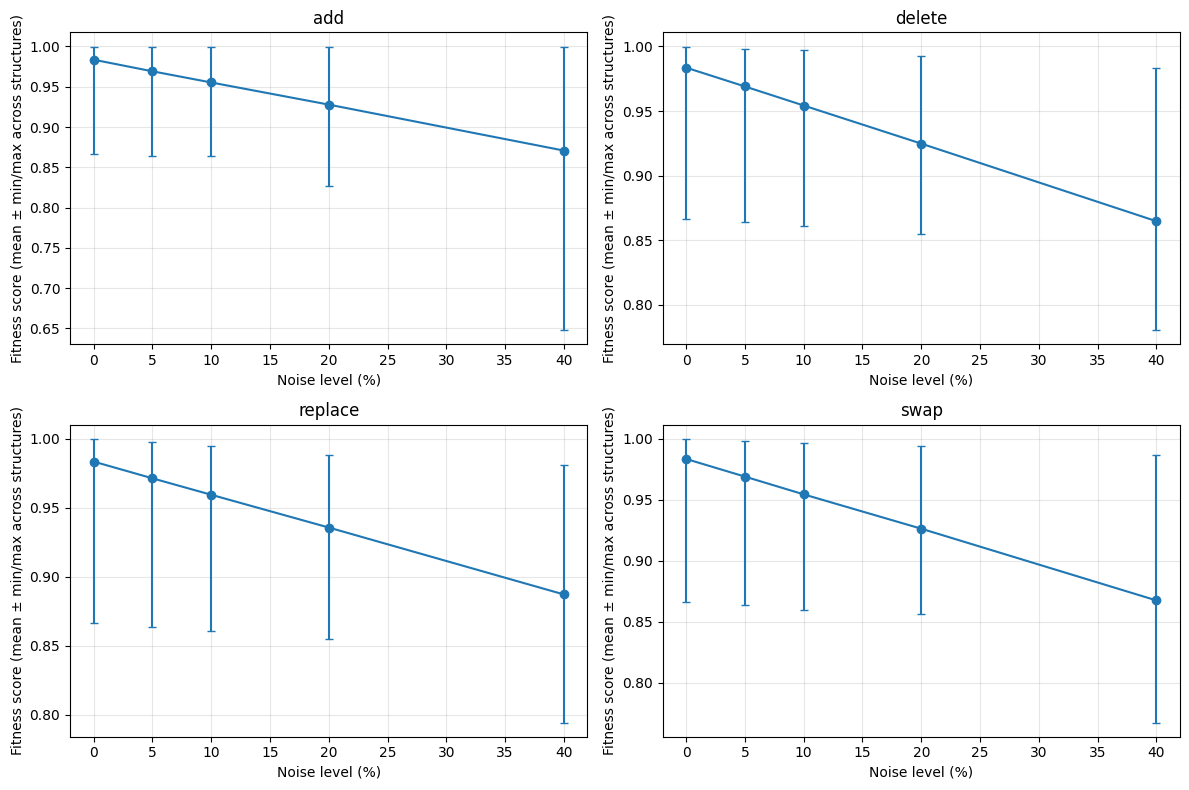

Saved: ../Data/Experiment2/experiment2_fitness_plots.png


In [ ]:
import os
import re
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# PM4Py
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.process_tree.importer import importer as ptml_importer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.simulation.playout.petri_net import algorithm as pn_playout


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = False 

print("Device:", DEVICE, "| AMP:", USE_AMP)


BASE = "../Data/Experiment2"
CSV_DIR = os.path.join(BASE, "CSV_Control_Flow")
PT_DIR  = os.path.join(BASE, "ProcessTrees")
PN_DIR  = os.path.join(BASE, "Petri_Nets")

assert os.path.isdir(CSV_DIR), f"Missing CSV dir: {CSV_DIR}"

def load_csv_trace_table(csv_path: str,
                         bos_token: str = "BOS",
                         eos_token: str = "EOS") -> List[List[str]]:
    df = pd.read_csv(csv_path, header=0)
    if len(df.columns) > 0 and str(df.columns[0]).lower().startswith("unnamed"):
        df = df.drop(columns=[df.columns[0]])

    traces: List[List[str]] = []
    for _, row in df.iterrows():
        toks: List[str] = []
        for cell in row.values:
            if pd.isna(cell):
                continue
            t = str(cell).strip()
            if t == "" or t.lower() == "nan":
                continue
            toks.append(t)

        if not toks:
            continue
        toks = [t for t in toks if t not in (bos_token, eos_token)]
        if toks:
            traces.append(toks)

    return traces

def model_tag(choice:int, parallel:int, loop:int) -> str:
    return f"Choice{choice:02d}_Parallel{parallel:02d}_Loop{loop:02d}"

def ptml_path(tag: str) -> str:
    return os.path.join(PT_DIR, f"PT_{tag}.ptml")

def pnml_path(tag: str) -> str:
    return os.path.join(PN_DIR, f"PN_{tag}.pnml")

def load_model_as_petri(tag: str):
    ptml = ptml_path(tag)
    pnml = pnml_path(tag)
    if os.path.isfile(ptml):
        pt = ptml_importer.apply(ptml)
        net, im, fm = pt_converter.apply(pt, variant=pt_converter.Variants.TO_PETRI_NET)
        return net, im, fm
    if os.path.isfile(pnml):
        net, im, fm = pnml_importer.apply(pnml)
        return net, im, fm
    raise FileNotFoundError(f"No PTML/PNML found for {tag}: {ptml} / {pnml}")

def playout_to_traces(net, im, fm, n_traces: int = 4000, max_trace_length: int = 200) -> List[List[str]]:
    # PM4Py playout returns an event log.
    params = {
        "no_traces": n_traces,
        "max_trace_length": max_trace_length,
        "activity_key": "concept:name",
    }
    elog = pn_playout.apply(net, im, fm, variant=pn_playout.Variants.BASIC_PLAYOUT, parameters=params)

    traces: List[List[str]] = []
    for case in elog:
        tr = []
        for ev in case:
            if "concept:name" in ev:
                tr.append(ev["concept:name"])
        if tr:
            traces.append(tr)
    return traces

PAD = "<PAD>"
UNK = "<UNK>"
CLS = "<CLS>"

def build_vocab(traces: List[List[str]], extra_tokens: Optional[List[str]] = None) -> Dict[str,int]:
    vocab = {PAD:0, UNK:1, CLS:2}
    if extra_tokens:
        for t in extra_tokens:
            if t not in vocab:
                vocab[t] = len(vocab)
    for tr in traces:
        for a in tr:
            if a not in vocab:
                vocab[a] = len(vocab)
    return vocab

def tokenize_trace(trace: List[str], vocab: Dict[str,int], max_len: int) -> List[int]:
    ids = [vocab.get(CLS, 2)]
    for a in trace[: max_len-1]:
        ids.append(vocab.get(a, vocab[UNK]))
    return ids

def corrupt_trace(trace: List[str], alphabet: List[str], noise: str, level: float) -> List[str]:
    """Apply one noise operator to a trace.
    level in [0,1] is probability/ratio controlling number of edits.
    """
    if not trace:
        return trace
    tr = trace.copy()
    n_edits = max(1, int(round(level * len(tr))))
    n_edits = min(n_edits, max(1, len(tr)))

    rng = random.Random(SEED + len(trace) + n_edits)

    if noise == "delete":
        for _ in range(n_edits):
            if not tr:
                break
            idx = rng.randrange(len(tr))
            tr.pop(idx)
        return tr if tr else trace[:1]

    if noise == "add":
        for _ in range(n_edits):
            idx = rng.randrange(len(tr)+1)
            tr.insert(idx, rng.choice(alphabet))
        return tr

    if noise == "replace":
        for _ in range(n_edits):
            idx = rng.randrange(len(tr))
            tr[idx] = rng.choice(alphabet)
        return tr

    if noise == "swap":
        for _ in range(n_edits):
            if len(tr) < 2:
                break
            i = rng.randrange(len(tr)-1)
            tr[i], tr[i+1] = tr[i+1], tr[i]
        return tr

    return tr

def generate_antilog_hybrid(positives: List[List[str]],
                            alphabet: List[str],
                            size: int,
                            noise_types: List[str] = ("add","delete","replace","swap"),
                            level: float = 0.3) -> List[List[str]]:
    """Generate negatives by corrupting randomly sampled positive traces."""
    negs: List[List[str]] = []
    rng = random.Random(SEED + 999)
    while len(negs) < size:
        base = rng.choice(positives)
        op = rng.choice(list(noise_types))
        neg = corrupt_trace(base, alphabet, op, level)
        negs.append(neg)
    return negs


class SeqDataset(Dataset):
    def __init__(self, X: List[List[int]], y: List[int]):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_dynamic_pad(batch):
    xs, ys = zip(*batch)
    maxlen = max(len(x) for x in xs)
    x_pad = torch.zeros(len(xs), maxlen, dtype=torch.long)
    attn  = torch.zeros(len(xs), maxlen, dtype=torch.bool)
    for i,x in enumerate(xs):
        x_pad[i, :len(x)] = torch.tensor(x, dtype=torch.long)
        attn[i, :len(x)] = True
    y = torch.tensor(ys, dtype=torch.long)
    return x_pad, attn, y


import math
import torch
import torch.nn as nn

class SinusoidalPositionalEncoding(nn.Module):
    """
    Standard sinusoidal positional encoding (Vaswani et al.).
    Adds fixed position-dependent vectors to token embeddings.
    """
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (T, D)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (T, 1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model)
        )  # (D/2,)

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims

        self.register_buffer("pe", pe.unsqueeze(0))  # (1, T, D)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        returns: (B, T, D) with positional encoding added
        """
        T = x.size(1)
        return x + self.pe[:, :T, :]


class TransformerClassifier(nn.Module):
    """
    Encoder-only Transformer discriminator.
    Input: token ids with [CLS] at position 0, padded with PAD=0.
    Uses sinusoidal positional encoding + attention mask to ignore PAD.
    Output: logits for 2 classes (log vs antilog), matching your existing BCE/CE setup.
    """
    def __init__(
        self,
        vocab_size: int,
        max_len: int,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        d_ff: int = 512,
        dropout: float = 0.0,
        pad_idx: int = 0,
    ):
        super().__init__()
        self.pad_idx = pad_idx

        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=False,
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)

        # 2-class head (log vs antilog). If you use a 1-logit sigmoid, change this to nn.Linear(d_model, 1).
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x: torch.Tensor, attn_mask_bool: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T) token ids
        attn_mask_bool: (B, T) True for real tokens, False for PAD
        returns: logits (B, 2)
        """
        # Embedding + positional encoding
        h = self.emb(x)           # (B, T, D)
        h = self.pos(h)           # (B, T, D)
        h = self.dropout(h)

        src_key_padding_mask = ~attn_mask_bool  # (B, T)

        h = self.enc(h, src_key_padding_mask=src_key_padding_mask)  # (B, T, D)

        # CLS pooling: take position 0
        cls = h[:, 0, :]  # (B, D)
        logits = self.fc(cls)
        return logits

@dataclass
class TrainCfg:
    lr: float = 2e-4
    epochs: int = 22
    batch_size: int = 32
    max_len: int = 96
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1

CFG = TrainCfg()

def train_discriminator(model: nn.Module, dl: DataLoader, epochs: int, lr: float, use_amp: bool=False) -> None:
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        total_loss = 0.0
        total = 0
        for x, attn, y in dl:
            x = x.to(DEVICE)
            attn = attn.to(DEVICE)
            y = y.to(DEVICE)

            opt.zero_grad(set_to_none=True)
            logits = model(x, attn)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()

            total_loss += float(loss.item()) * y.size(0)
            total += y.size(0)

        print(f"  epoch {ep:02d}/{epochs} | loss={total_loss/max(1,total):.4f}")

@torch.no_grad()
def score_mean_positive_prob(model: nn.Module, X_tok: List[List[int]]) -> float:
    """Return mean P(class=1) over X_tok."""
    model.eval()
    bs = 256
    probs = []
    for i in range(0, len(X_tok), bs):
        chunk = X_tok[i:i+bs]
        maxlen = max(len(x) for x in chunk)
        x_pad = torch.zeros(len(chunk), maxlen, dtype=torch.long)
        attn  = torch.zeros(len(chunk), maxlen, dtype=torch.bool)
        for j,x in enumerate(chunk):
            x_pad[j,:len(x)] = torch.tensor(x, dtype=torch.long)
            attn[j,:len(x)] = True
        x_pad = x_pad.to(DEVICE)
        attn  = attn.to(DEVICE)
        logits = model(x_pad, attn)
        p = F.softmax(logits, dim=-1)[:,1]
        probs.append(p.detach().cpu().numpy())
    return float(np.mean(np.concatenate(probs))) if probs else float("nan")

TAG_RE = re.compile(r"Choice\d{2}_Parallel\d{2}_Loop\d{2}")
FILE_RE = re.compile(r"Event_Log_(add|delete|replace|swap)_(\d+)\.csv$", re.I)

def discover_event_logs(csv_root: str) -> Dict[str, Dict[Tuple[str,int], str]]:
    """
    Returns:
      dict[tag][(noise_type, level_int)] = csv_path
    Also detects clean logs as (noise_type='clean', level=0) when filename doesn't match FILE_RE.
    """
    mapping: Dict[str, Dict[Tuple[str,int], str]] = {}

    for root, _, files in os.walk(csv_root):
        for fn in files:
            if not fn.lower().endswith(".csv"):
                continue
            full = os.path.join(root, fn)

            # Determine tag from path components
            parts = full.replace("\\", "/").split("/")
            tag = None
            for p in reversed(parts):
                if TAG_RE.fullmatch(p):
                    tag = p
                    break
            if tag is None:
                mtag = TAG_RE.search(fn)
                if mtag:
                    tag = mtag.group(0)
                else:
                    continue

            mapping.setdefault(tag, {})

            m = FILE_RE.search(fn)
            if m:
                ntype = m.group(1).lower()
                lvl = int(m.group(2))
                mapping[tag][(ntype, lvl)] = full
            else:
                # treat as clean
                mapping[tag][("clean", 0)] = full

    return mapping

event_logs = discover_event_logs(CSV_DIR)

if not event_logs:
    raise RuntimeError(f"No CSV logs discovered under {CSV_DIR}. Check naming like Event_Log_add_10.csv and folder tags Choice..")

all_tags = sorted(event_logs.keys())
print("Discovered structures:", len(all_tags))
print("Example tags:", all_tags[:5])

# Determine available levels per noise type (from data!)
noise_types = ["add","delete","replace","swap"]
levels_by_noise: Dict[str, List[int]] = {nt: [] for nt in noise_types}
for tag in all_tags:
    for (nt, lvl), _ in event_logs[tag].items():
        if nt in noise_types:
            levels_by_noise[nt].append(lvl)

for nt in noise_types:
    lvls = sorted(set(levels_by_noise[nt]))
    levels_by_noise[nt] = lvls
    print(f"Noise '{nt}': levels found:", lvls)

results = []

for tag in all_tags:
    print("\n==============================")
    print("Structure:", tag)

    # Load model log once
    net, im, fm = load_model_as_petri(tag)
    model_traces = playout_to_traces(net, im, fm, n_traces=4000, max_trace_length=200)

    # Build alphabet and vocab
    alphabet = sorted({a for tr in model_traces for a in tr})
    vocab = build_vocab(model_traces)

    # Tokenize model positives
    X_pos = [tokenize_trace(tr, vocab, CFG.max_len) for tr in model_traces]

    # Create antilog negatives (size matched to positives)
    neg_traces = generate_antilog_hybrid(model_traces, alphabet, size=len(model_traces), level=0.3)
    X_neg = [tokenize_trace(tr, vocab, CFG.max_len) for tr in neg_traces]

    # Train discriminator once per structure
    X = X_pos + X_neg
    y = [1]*len(X_pos) + [0]*len(X_neg)

    ds = SeqDataset(X, y)
    dl = DataLoader(ds, batch_size=CFG.batch_size, shuffle=True, collate_fn=collate_dynamic_pad, num_workers=0)
    vocab_size = len(vocab)
    clf  = TransformerClassifier(
     vocab_size=vocab_size,
     max_len=CFG.max_len,
     d_model=128,
     n_heads=4,
     n_layers=2,
     d_ff=512,
     dropout=0.0,
     pad_idx=0
 ).to(DEVICE)

    train_discriminator(clf, dl, epochs=CFG.epochs, lr=CFG.lr, use_amp=USE_AMP)

    
    # Optionally score clean (no-noise) event log for this structure if present
    clean_path = event_logs.get(tag, {}).get(("clean", 0))
    if clean_path:
        ev_clean = load_csv_trace_table(clean_path)
        X_clean = [tokenize_trace(tr, vocab, CFG.max_len) for tr in ev_clean]
        clean_score = score_mean_positive_prob(clf, X_clean)
        results.append({
            "structure": tag,
            "noise_type": "clean",
            "noise_level": 0,
            "fitness_score": float(clean_score),
            "n_event_traces": len(ev_clean),
            "n_model_traces": len(model_traces),
            "model_source": "PTML" if os.path.isfile(ptml_path(tag)) else "PNML",
        })
# Score each available noisy CSV for this structure
    for nt in noise_types:
        for lvl in levels_by_noise[nt]:
            csv_path = event_logs.get(tag, {}).get((nt, lvl))
            if not csv_path:
                continue
            ev_traces = load_csv_trace_table(csv_path)
            X_ev = [tokenize_trace(tr, vocab, CFG.max_len) for tr in ev_traces]
            score = score_mean_positive_prob(clf, X_ev)

            results.append({
                "structure": tag,
                "noise_type": nt,
                "noise_level": int(lvl),
                "fitness_score": float(score),
                "n_event_traces": len(ev_traces),
                "n_model_traces": len(model_traces),
                "model_source": "PTML" if os.path.isfile(ptml_path(tag)) else "PNML",
            })

df_results = pd.DataFrame(results)
print("\nDone. Rows:", len(df_results))
display(df_results.head())


# Save raw results
os.makedirs(BASE, exist_ok=True)
out_csv = os.path.join(BASE, "experiment2_transformer_results.csv")
df_results.to_csv(out_csv, index=False)
print("Saved:", out_csv)

agg_rows = []
for nt in noise_types:
    for lvl in sorted(df_results.loc[df_results["noise_type"]==nt, "noise_level"].unique()):
        sub = df_results[(df_results["noise_type"]==nt) & (df_results["noise_level"]==lvl)]
        if sub.empty:
            continue
        agg_rows.append({
            "noise_type": nt,
            "noise_level": int(lvl),
            "mean": float(sub["fitness_score"].mean()),
            "min": float(sub["fitness_score"].min()),
            "max": float(sub["fitness_score"].max()),
            "n_structures": int(sub["structure"].nunique()),
        })
df_agg = pd.DataFrame(agg_rows).sort_values(["noise_type","noise_level"])
clean_sub = df_results[df_results["noise_type"]=="clean"]
if not clean_sub.empty:
    base = {
        "mean": float(clean_sub["fitness_score"].mean()),
        "min": float(clean_sub["fitness_score"].min()),
        "max": float(clean_sub["fitness_score"].max()),
        "n_structures": int(clean_sub["structure"].nunique()),
    }
    baseline_rows = []
    for nt in noise_types:
        baseline_rows.append({
            "noise_type": nt,
            "noise_level": 0,
            **base
        })
    df_agg = pd.concat([pd.DataFrame(baseline_rows), df_agg], ignore_index=True).sort_values(["noise_type","noise_level"])

display(df_agg)

# Plot (2×2 grid): add/delete/replace/swap
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, nt in enumerate(noise_types):
    ax = axes[i]
    sub = df_agg[df_agg["noise_type"]==nt].sort_values("noise_level")
    x = sub["noise_level"].to_numpy()
    y = sub["mean"].to_numpy()
    yerr_low = y - sub["min"].to_numpy()
    yerr_high = sub["max"].to_numpy() - y
    ax.errorbar(x, y, yerr=[yerr_low, yerr_high], marker="o", capsize=3)
    ax.set_title(nt)
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Fitness score (mean ± min/max across structures)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
out_png = os.path.join(BASE, "experiment2_fitness_plots.png")
plt.savefig(out_png, dpi=200)
plt.show()
print("Saved:", out_png)


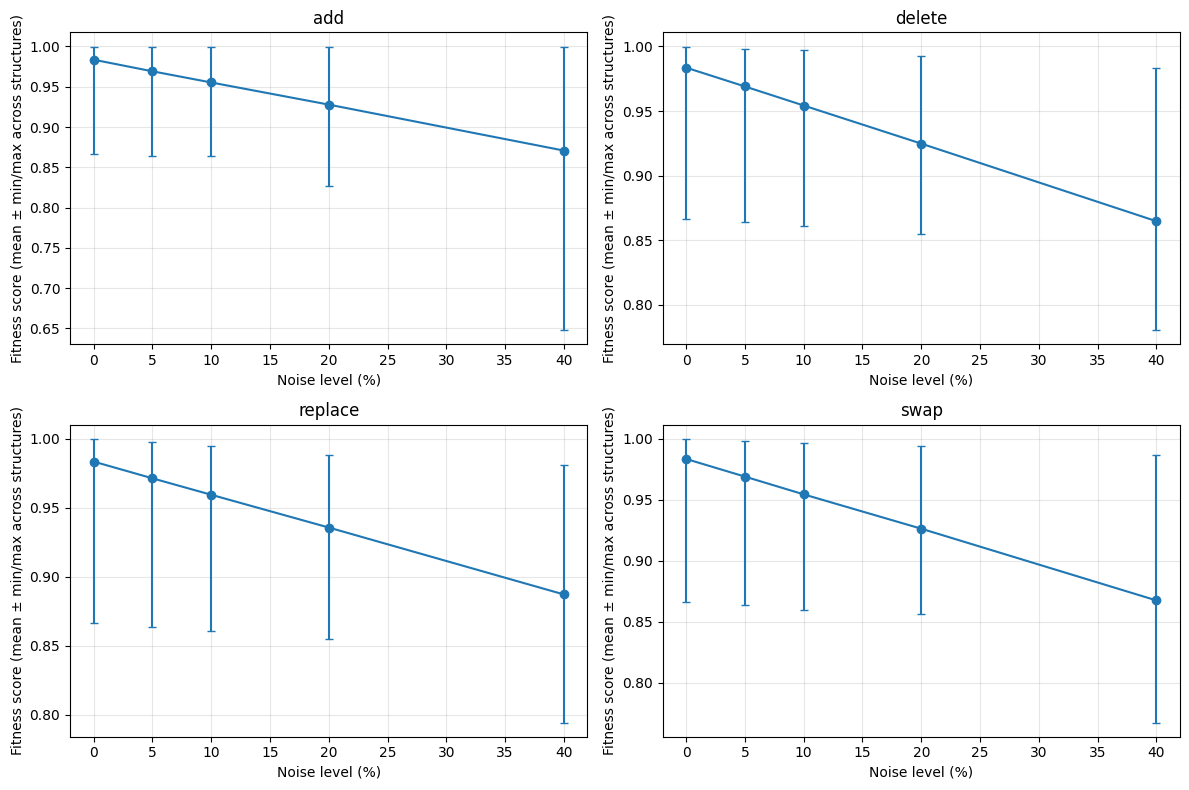

Saved: ../Data/Experiment2/experiment2_fitness_plots.png
Saved: ../Data/Experiment2/experiment2_fitness_plots.pdf


In [ ]:
# Results plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, nt in enumerate(noise_types):
    ax = axes[i]
    sub = df_agg[df_agg["noise_type"]==nt].sort_values("noise_level")
    x = sub["noise_level"].to_numpy()
    y = sub["mean"].to_numpy()
    yerr_low = y - sub["min"].to_numpy()
    yerr_high = sub["max"].to_numpy() - y
    ax.errorbar(x, y, yerr=[yerr_low, yerr_high], marker="o", capsize=3)
    ax.set_title(nt)
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Fitness score (mean ± min/max across structures)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save PNG
out_png = os.path.join(BASE, "experiment2_fitness_plots.png")
plt.savefig(out_png, dpi=200)

# Save PDF (vector, best for papers)
out_pdf = os.path.join(BASE, "experiment2_fitness_plots.pdf")
plt.savefig(out_pdf, bbox_inches="tight")

plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)


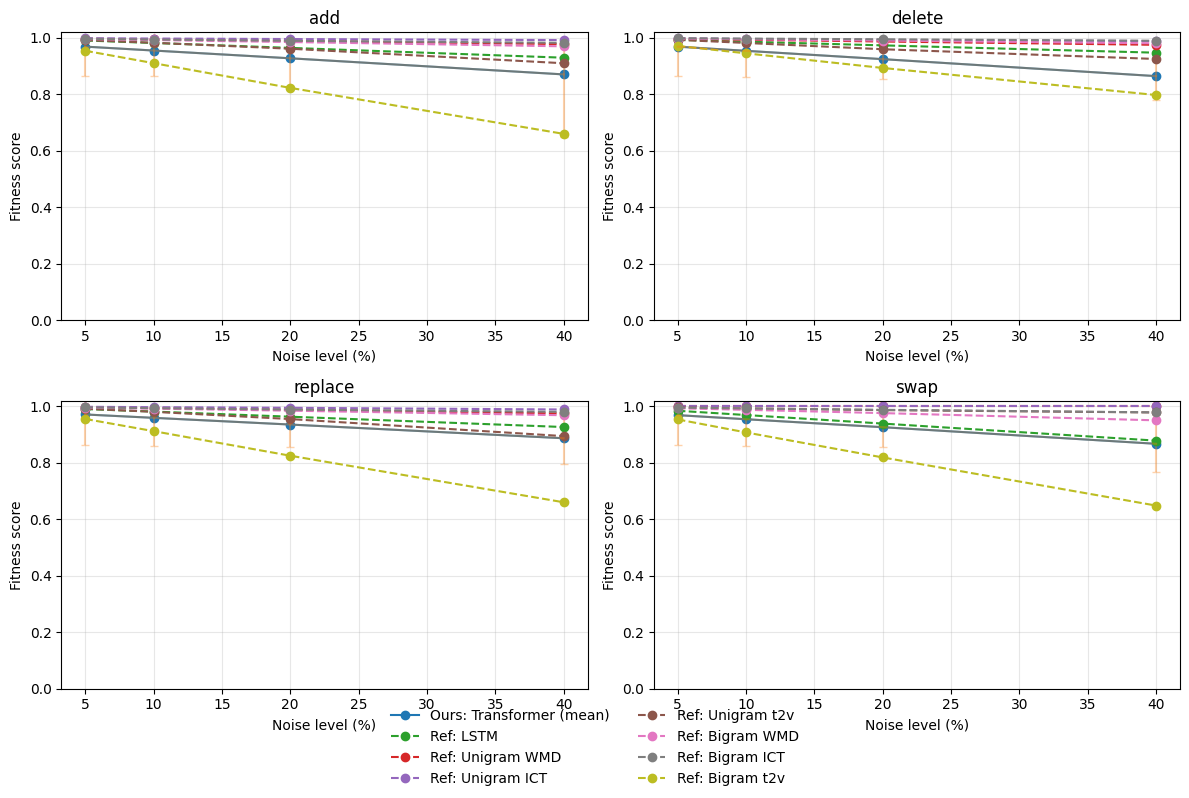

Saved: ../Data/Experiment2/experiment2_fitness_ours_vs_reference.png
Saved: ../Data/Experiment2/experiment2_fitness_ours_vs_reference.pdf


In [ ]:
# Plot Experiment 2: Our Transformer vs Reference Work

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE = "../Data/Experiment2"
OUR_CSV = os.path.join(BASE, "experiment2_transformer_results.csv")

REF_DIR = "../Data/Full_Results_Experiment2" 

REF_FILES = {
    "Ref: LSTM": "LSTM_Results_Experiment2.csv",
    "Ref: Unigram WMD": "Unigram_WMD_Results_Experiment2.csv",
    "Ref: Unigram ICT": "Unigram_ICT_Results_Experiment2.csv",
    "Ref: Unigram t2v": "Unigram_t2v_Results_Experiment2.csv",
    "Ref: Bigram WMD": "Bigram_WMD_Results_Experiment2.csv",
    "Ref: Bigram ICT": "Bigram_ICT_Results_Experiment2.csv",
    "Ref: Bigram t2v": "Bigram_t2v_Results_Experiment2.csv",
}

noise_types = ["add", "delete", "replace", "swap"]

def agg_ours(df_ours: pd.DataFrame) -> pd.DataFrame:
    """
    df_ours columns expected:
      structure, noise_type, noise_level, fitness_score
    Returns aggregated rows per (noise_type, noise_level): mean/min/max
    """
    df = df_ours.copy()
    df["noise_type"] = df["noise_type"].str.lower()

    out = (
        df[df["noise_type"].isin(noise_types + ["clean"])]
        .groupby(["noise_type", "noise_level"], as_index=False)["fitness_score"]
        .agg(mean="mean", min="min", max="max")
        .sort_values(["noise_type", "noise_level"])
    )
    return out

def load_ref_csv(path: str) -> pd.DataFrame:
    """
    Reference CSV format (typical):
      Choice, Parallel, Loop, Noise Level, Add, Delete, Replace, Swap
    Noise Level can be like '5%' or '5' or 5
    """
    df = pd.read_csv(path)

    # normalize column names
    df.columns = [c.strip() for c in df.columns]

    # detect noise-level col name
    nl_col = None
    for cand in ["Noise Level", "Noise level", "Noise", "NoiseLevel", "noise_level"]:
        if cand in df.columns:
            nl_col = cand
            break
    if nl_col is None:
        raise ValueError(f"Could not find a Noise Level column in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    def parse_lvl(x):
        if pd.isna(x):
            return np.nan
        s = str(x).strip()
        s = s.replace("%", "")
        return int(float(s))
    df["noise_level"] = df[nl_col].apply(parse_lvl)

    col_map = {}
    for nt in noise_types:
        for c in df.columns:
            if c.strip().lower() == nt:
                col_map[nt] = c
                break
    missing = [nt for nt in noise_types if nt not in col_map]
    if missing:
        raise ValueError(f"Missing noise columns {missing} in {os.path.basename(path)}. Columns: {df.columns.tolist()}")

    long = []
    for nt in noise_types:
        tmp = df[["noise_level", col_map[nt]]].copy()
        tmp.rename(columns={col_map[nt]: "fitness_score"}, inplace=True)
        tmp["noise_type"] = nt
        long.append(tmp)

    out = pd.concat(long, ignore_index=True)
    out["fitness_score"] = pd.to_numeric(out["fitness_score"], errors="coerce")
    out = out.dropna(subset=["noise_level", "fitness_score"])

    # Aggregate across structures (each row is one structure configuration)
    agg = (
        out.groupby(["noise_type", "noise_level"], as_index=False)["fitness_score"]
           .agg(mean="mean", min="min", max="max")
           .sort_values(["noise_type", "noise_level"])
    )
    return agg

assert os.path.isfile(OUR_CSV), f"Missing our results CSV at: {OUR_CSV}"
df_ours_raw = pd.read_csv(OUR_CSV)
df_ours_agg = agg_ours(df_ours_raw)


ref_aggs = {}
for label, fn in REF_FILES.items():
    fpath = os.path.join(REF_DIR, fn)
    if not os.path.isfile(fpath):
        print(f"[skip] Not found: {fpath}")
        continue
    ref_aggs[label] = load_ref_csv(fpath)

if not ref_aggs:
    raise RuntimeError(
        "No reference CSVs were loaded. Check REF_DIR and filenames in REF_FILES."
    )

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, nt in enumerate(noise_types):
    ax = axes[i]

    sub_o = df_ours_agg[df_ours_agg["noise_type"] == nt].sort_values("noise_level")
    if not sub_o.empty:
        x = sub_o["noise_level"].to_numpy()
        y = sub_o["mean"].to_numpy()
        ax.plot(x, y, marker="o", label="Ours: Transformer (mean)")
        yerr_low = y - sub_o["min"].to_numpy()
        yerr_high = sub_o["max"].to_numpy() - y
        ax.errorbar(x, y, yerr=[yerr_low, yerr_high], capsize=3, alpha=0.35)

    for label, agg in ref_aggs.items():
        sub_r = agg[agg["noise_type"] == nt].sort_values("noise_level")
        if sub_r.empty:
            continue
        xr = sub_r["noise_level"].to_numpy()
        yr = sub_r["mean"].to_numpy()
        ax.plot(xr, yr, marker="o", linestyle="--", label=label)

    ax.set_title(nt)
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Fitness score")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.0, 1.02)

# one legend for whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.06, 1, 1])

out_png = os.path.join(BASE, "experiment2_fitness_ours_vs_reference.png")
out_pdf = os.path.join(BASE, "experiment2_fitness_ours_vs_reference.pdf")
plt.savefig(out_png, dpi=200)
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved:", out_png)
print("Saved:", out_pdf)


## Experiment 3

In [ ]:
import re

def norm_act(a: str) -> str:
    a = a.strip().lower()
    a = re.sub(r"\s+", "", a)
    a = re.sub(r"[()]", "", a)
    a = re.sub(r"[,&\-]", "", a)
    return a

## Experiment 3

Device: cuda | AMP: False

Dataset: BPIC_2017
Log: ../Data/Experiment3/Only_Control_Flow_csv/BPIC_2017.csv


/tmp/ipykernel_78418/1636205789.py:65: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, header=0)


  Loaded event log traces: 31509
  Models found: [0, 25, 50, 75, 100]

-----------------------------------------
  Model level 0: BPIC_2017_00.pnml
    [playout batching] collected=5000/30000
    [playout batching] collected=10000/30000
    [playout batching] collected=15000/30000
    [playout batching] collected=20000/30000
    [playout batching] collected=25000/30000
    [playout batching] collected=30000/30000
    [playout] requested=30000 | produced=30000 | max_len=400
    Payout model traces: 30000
    Training fitness discriminator...
    epoch 01/14 | loss=0.4412
    epoch 02/14 | loss=0.3788
    epoch 03/14 | loss=0.3751
    epoch 04/14 | loss=0.3773
    epoch 05/14 | loss=0.3676
    epoch 06/14 | loss=0.3682
    epoch 07/14 | loss=0.3553
    epoch 08/14 | loss=0.3528
    epoch 09/14 | loss=0.3493
    epoch 10/14 | loss=0.3448
    epoch 11/14 | loss=0.3422
    epoch 12/14 | loss=0.3415
    epoch 13/14 | loss=0.3457
    epoch 14/14 | loss=0.3452
    Training precision discrimina

/tmp/ipykernel_78418/1636205789.py:65: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, header=0)


  Loaded event log traces: 98479
  Models found: [0, 25, 50, 75, 100]

-----------------------------------------
  Model level 0: Hospital_filtered_00.pnml
    [playout batching] collected=4956/30000
    [playout batching] collected=9909/30000
    [playout batching] collected=14882/30000
    [playout batching] collected=19835/30000
    [playout batching] collected=24787/30000
    [playout batching] collected=29740/30000
    [playout] requested=30000 | produced=30731 | max_len=400
    Payout model traces: 30000
    Training fitness discriminator...
    epoch 01/14 | loss=0.5743
    epoch 02/14 | loss=0.5110
    epoch 03/14 | loss=0.4968
    epoch 04/14 | loss=0.4867
    epoch 05/14 | loss=0.4804
    epoch 06/14 | loss=0.4795
    epoch 07/14 | loss=0.4740
    epoch 08/14 | loss=0.4727
    epoch 09/14 | loss=0.4696
    epoch 10/14 | loss=0.4672
    epoch 11/14 | loss=0.4653
    epoch 12/14 | loss=0.4648
    epoch 13/14 | loss=0.4639
    epoch 14/14 | loss=0.4619
    Training precision dis

/tmp/ipykernel_78418/1636205789.py:65: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, header=0)


  Loaded event log traces: 100000
  Models found: [0, 25, 50, 75, 100]

-----------------------------------------
  Model level 0: Hospital_00.pnml
    [playout batching] collected=5000/30000
    [playout batching] collected=10000/30000
    [playout batching] collected=15000/30000
    [playout batching] collected=20000/30000
    [playout batching] collected=25000/30000
    [playout batching] collected=30000/30000
    [playout] requested=30000 | produced=30000 | max_len=400
    Payout model traces: 30000
    Training fitness discriminator...
    epoch 01/14 | loss=0.6178
    epoch 02/14 | loss=0.5601
    epoch 03/14 | loss=0.5443
    epoch 04/14 | loss=0.5347
    epoch 05/14 | loss=0.5311
    epoch 06/14 | loss=0.5254
    epoch 07/14 | loss=0.5216
    epoch 08/14 | loss=0.5172
    epoch 09/14 | loss=0.5141
    epoch 10/14 | loss=0.5133
    epoch 11/14 | loss=0.5105
    epoch 12/14 | loss=0.5086
    epoch 13/14 | loss=0.5064
    epoch 14/14 | loss=0.5044
    Training precision discrimina

/tmp/ipykernel_78418/1636205789.py:65: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, header=0)


  Loaded event log traces: 150370
  Models found: [0, 25, 50, 75, 100]

-----------------------------------------
  Model level 0: RTFM_00.pnml
    [playout batching] collected=5000/30000
    [playout batching] collected=10000/30000
    [playout batching] collected=15000/30000
    [playout batching] collected=20000/30000
    [playout batching] collected=25000/30000
    [playout batching] collected=30000/30000
    [playout] requested=30000 | produced=30000 | max_len=400
    Payout model traces: 30000
    Training fitness discriminator...
    epoch 01/14 | loss=0.4538
    epoch 02/14 | loss=0.4145
    epoch 03/14 | loss=0.4062
    epoch 04/14 | loss=0.3978
    epoch 05/14 | loss=0.3911
    epoch 06/14 | loss=0.3844
    epoch 07/14 | loss=0.3813
    epoch 08/14 | loss=0.3792
    epoch 09/14 | loss=0.3762
    epoch 10/14 | loss=0.3744
    epoch 11/14 | loss=0.3727
    epoch 12/14 | loss=0.3697
    epoch 13/14 | loss=0.3697
    epoch 14/14 | loss=0.3688
    Training precision discriminator.

,dataset,model_level,fitness,precision,n_L,n_LM,pnml
0,BPIC_2017,0,0.342739,0.000195,31509,30000,BPIC_2017_00.pnml
1,BPIC_2017,25,0.220683,0.011612,31509,30000,BPIC_2017_25.pnml
2,BPIC_2017,50,0.000139,0.168514,31509,30000,BPIC_2017_50.pnml
3,BPIC_2017,75,0.000200,0.014618,31509,30000,BPIC_2017_75.pnml
4,BPIC_2017,100,0.000300,0.257187,31509,30000,BPIC_2017_100.pnml
5,Helpdesk,0,0.349544,0.008076,4580,30000,Helpdesk_00.pnml
6,Helpdesk,25,0.688525,0.335154,4580,30000,Helpdesk_25.pnml
7,Helpdesk,50,0.485550,0.100000,4580,30000,Helpdesk_50.pnml
8,Helpdesk,75,0.506154,0.051819,4580,30000,Helpdesk_75.pnml
9,Helpdesk,100,0.000272,0.029537,4580,30000,Helpdesk_100.pnml


Saved: ../Data/Experiment3/experiment3_transformer_results.csv


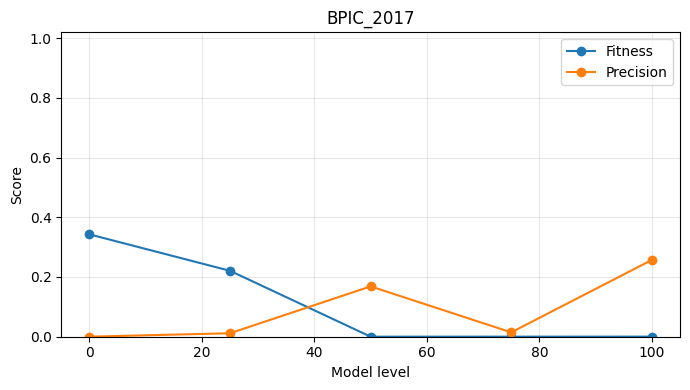

Saved: ../Data/Experiment3/experiment3_BPIC_2017_fitness_precision.png
Saved: ../Data/Experiment3/experiment3_BPIC_2017_fitness_precision.pdf


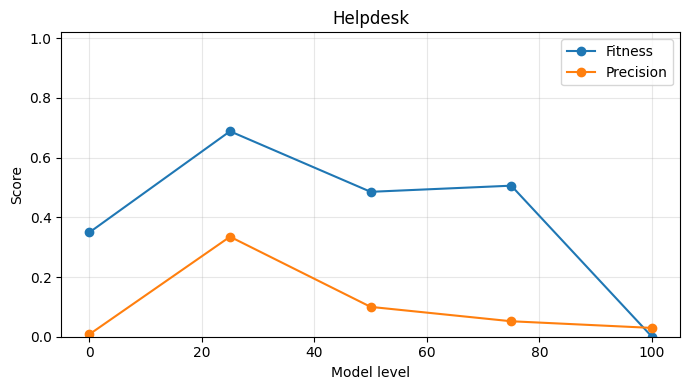

Saved: ../Data/Experiment3/experiment3_Helpdesk_fitness_precision.png
Saved: ../Data/Experiment3/experiment3_Helpdesk_fitness_precision.pdf


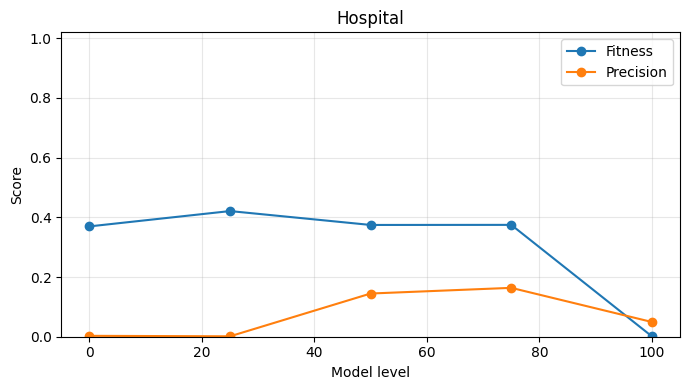

Saved: ../Data/Experiment3/experiment3_Hospital_fitness_precision.png
Saved: ../Data/Experiment3/experiment3_Hospital_fitness_precision.pdf


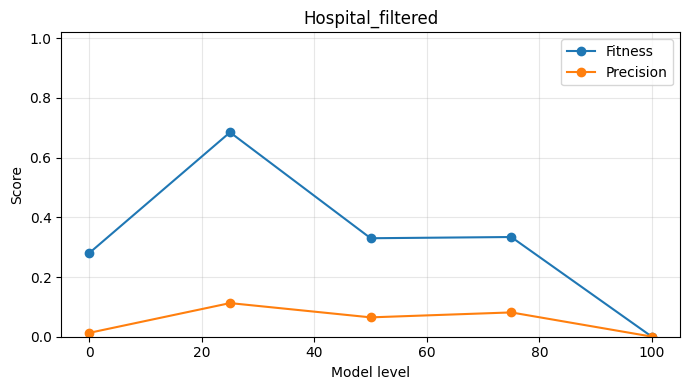

Saved: ../Data/Experiment3/experiment3_Hospital_filtered_fitness_precision.png
Saved: ../Data/Experiment3/experiment3_Hospital_filtered_fitness_precision.pdf


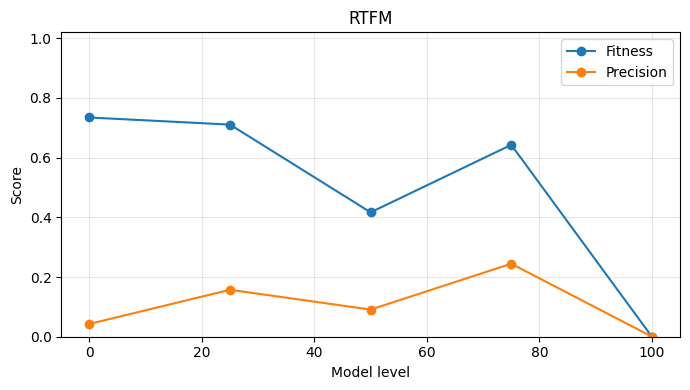

Saved: ../Data/Experiment3/experiment3_RTFM_fitness_precision.png
Saved: ../Data/Experiment3/experiment3_RTFM_fitness_precision.pdf


In [ ]:


import os
import re
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.simulation.playout.petri_net import algorithm as pn_playout

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = False  # keep FP32 for ROCm stability
print("Device:", DEVICE, "| AMP:", USE_AMP)

BASE = "../Data/Experiment3"
MODELS_DIR = os.path.join(BASE, "Models")
LOGS_DIR   = os.path.join(BASE, "Only_Control_Flow_csv")

assert os.path.isdir(MODELS_DIR), f"Missing: {MODELS_DIR}"
assert os.path.isdir(LOGS_DIR), f"Missing: {LOGS_DIR}"

# DATASETS = ["BPIC_2017"]
DATASETS = ["BPIC_2017", "Helpdesk", "Hospital_filtered", "Hospital", "RTFM"]


def load_csv_trace_table(csv_path: str,
                         bos_token: str = "BOS",
                         eos_token: str = "EOS") -> List[List[str]]:
    df = pd.read_csv(csv_path, header=0)
    # drop accidental index column
    if len(df.columns) > 0 and str(df.columns[0]).lower().startswith("unnamed"):
        df = df.drop(columns=[df.columns[0]])

    traces: List[List[str]] = []
    for _, row in df.iterrows():
        toks: List[str] = []
        for cell in row.values:
            if pd.isna(cell):
                continue
            t = str(cell).strip()
            if t == "" or t.lower() == "nan":
                continue
            toks.append(norm_act(t))

        if not toks:
            continue
        toks = [t for t in toks if t not in (bos_token, eos_token)]
        if toks:
            traces.append(toks)
    return traces

# Model discovery: <DATASET>_<LEVEL>.pnml  (LEVEL = 00/25/50/75/100 etc.)
MODEL_RE = re.compile(r"^(?P<name>.+)_(?P<lvl>\d{2,3})\.pnml$", re.I)

def discover_models(models_dir: str) -> Dict[str, List[Tuple[int, str]]]:
    """
    Returns mapping: dataset_name -> list of (level_int, file_path) sorted by level
    """
    mapping: Dict[str, List[Tuple[int, str]]] = {}
    for fn in os.listdir(models_dir):
        m = MODEL_RE.match(fn)
        if not m:
            continue
        name = m.group("name")
        lvl = int(m.group("lvl"))
        path = os.path.join(models_dir, fn)
        mapping.setdefault(name, []).append((lvl, path))
    for name in mapping:
        mapping[name] = sorted(mapping[name], key=lambda x: x[0])
    return mapping

models_map = discover_models(MODELS_DIR)

def load_pnml_model(pnml_path: str):
    net, im, fm = pnml_importer.apply(pnml_path)
    return net, im, fm

def playout_to_traces(net, im, fm, n_traces: int = 20000, max_trace_length: int = 400) -> List[List[str]]:
    out: List[List[str]] = []
    batch = 1000 
    tries = 0

    while len(out) < n_traces:
        tries += 1
        params = {
            "no_traces": min(batch, n_traces - len(out)),
            "max_trace_length": max_trace_length,
            "activity_key": "concept:name",
        }

        elog = pn_playout.apply(
            net, im, fm,
            variant=pn_playout.Variants.BASIC_PLAYOUT,
            parameters=params
        )

        for case in elog:
            tr = []
            for ev in case:
                if "concept:name" in ev:
                    tr.append(norm_act(ev["concept:name"]))
            if tr:
                out.append(tr)

        # safety: if PM4Py returns nothing, stop to avoid infinite loop
        if tries > 100 and len(out) == 0:
            break

        if tries % 5 == 0:
            print(f"    [playout batching] collected={len(out)}/{n_traces}")

    print(f"    [playout] requested={n_traces} | produced={len(out)} | max_len={max_trace_length}")
    return out[:n_traces]


PAD = "<PAD>"
UNK = "<UNK>"
CLS = "<CLS>"

def build_vocab_from_union(traces_a: List[List[str]], traces_b: List[List[str]]) -> Dict[str, int]:
    vocab = {PAD: 0, UNK: 1, CLS: 2}
    for tr in (traces_a + traces_b):
        for a in tr:
            if a not in vocab:
                vocab[a] = len(vocab)
    return vocab

def tokenize_trace(trace: List[str], vocab: Dict[str, int], max_len: int) -> List[int]:
    ids = [vocab[CLS]]
    for a in trace[: max_len - 1]:
        ids.append(vocab.get(a, vocab[UNK]))
    return ids

def corrupt_trace(trace: List[str], alphabet: List[str], noise: str, level: float, rng: random.Random) -> List[str]:
    if not trace:
        return trace
    tr = trace.copy()
    n_edits = max(1, int(round(level * len(tr))))
    n_edits = min(n_edits, max(1, len(tr)))

    if noise == "delete":
        for _ in range(n_edits):
            if not tr:
                break
            idx = rng.randrange(len(tr))
            tr.pop(idx)
        return tr if tr else trace[:1]

    if noise == "add":
        for _ in range(n_edits):
            idx = rng.randrange(len(tr) + 1)
            tr.insert(idx, rng.choice(alphabet))
        return tr

    if noise == "replace":
        for _ in range(n_edits):
            idx = rng.randrange(len(tr))
            tr[idx] = rng.choice(alphabet)
        return tr

    if noise == "swap":
        for _ in range(n_edits):
            if len(tr) < 2:
                break
            i = rng.randrange(len(tr) - 1)
            tr[i], tr[i + 1] = tr[i + 1], tr[i]
        return tr

    return tr

def generate_antilog_mixed(positives: List[List[str]],
                           alphabet: List[str],
                           size: int,
                           levels: Tuple[float, ...],
                           noise_types: Tuple[str, ...],
                           seed: int = 0) -> List[List[str]]:
    rng = random.Random(SEED + seed)
    negs: List[List[str]] = []
    while len(negs) < size:
        base = rng.choice(positives)
        op = rng.choice(list(noise_types))
        lvl = rng.choice(list(levels))
        negs.append(corrupt_trace(base, alphabet, op, lvl, rng))
    return negs


class SeqDataset(Dataset):
    def __init__(self, X: List[List[int]], y: List[int]):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_dynamic_pad(batch):
    xs, ys = zip(*batch)
    maxlen = max(len(x) for x in xs)
    x_pad = torch.zeros(len(xs), maxlen, dtype=torch.long)
    attn  = torch.zeros(len(xs), maxlen, dtype=torch.bool)
    for i, x in enumerate(xs):
        x_pad[i, :len(x)] = torch.tensor(x, dtype=torch.long)
        attn[i, :len(x)] = True
    y = torch.tensor(ys, dtype=torch.long)
    return x_pad, attn, y

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, T, D)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        T = x.size(1)
        return x + self.pe[:, :T, :]

class TransformerClassifier(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 max_len: int,
                 d_model: int = 128,
                 n_heads: int = 4,
                 n_layers: int = 2,
                 d_ff: int = 512,
                 dropout: float = 0.0,
                 pad_idx: int = 0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True,
            activation="relu",   
            norm_first=False    
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x: torch.Tensor, attn_mask_bool: torch.Tensor) -> torch.Tensor:
        h = self.emb(x)
        h = self.pos(h)
        src_key_padding_mask = ~attn_mask_bool  # True means ignore
        h = self.enc(h, src_key_padding_mask=src_key_padding_mask)
        cls = h[:, 0, :]
        return self.fc(cls)

# Training + scoring
@dataclass
class TrainCfg:
    lr: float = 3e-4
    epochs: int = 14
    batch_size: int = 16          
    max_len: int = 192           
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    d_ff: int = 512
    dropout: float = 0.1        
    n_playout: int = 30000      
    max_trace_len_playout: int = 400
    antilog_levels: Tuple[float, ...] = (0.10, 0.30, 0.50)  # mix easy/med/hard
    anti_noise_types: Tuple[str, ...] = ("add","delete","replace","swap")

CFG = TrainCfg()

def train_discriminator(model: nn.Module, dl: DataLoader, epochs: int, lr: float) -> None:
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for ep in range(1, epochs + 1):
        total_loss, total = 0.0, 0
        for x, attn, y in dl:
            x, attn, y = x.to(DEVICE), attn.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x, attn)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()
            total_loss += float(loss.item()) * y.size(0)
            total += y.size(0)
        print(f"    epoch {ep:02d}/{epochs} | loss={total_loss/max(1,total):.4f}")

@torch.no_grad()
def mean_pos_prob(model: nn.Module, X_tok: List[List[int]], bs: int = 256) -> float:
    model.eval()
    probs = []
    for i in range(0, len(X_tok), bs):
        chunk = X_tok[i:i+bs]
        maxlen = max(len(x) for x in chunk)
        x_pad = torch.zeros(len(chunk), maxlen, dtype=torch.long)
        attn  = torch.zeros(len(chunk), maxlen, dtype=torch.bool)
        for j, x in enumerate(chunk):
            x_pad[j, :len(x)] = torch.tensor(x, dtype=torch.long)
            attn[j, :len(x)] = True
        x_pad, attn = x_pad.to(DEVICE), attn.to(DEVICE)
        logits = model(x_pad, attn)
        p = F.softmax(logits, dim=-1)[:, 1]
        probs.append(p.detach().cpu().numpy())
    return float(np.mean(np.concatenate(probs))) if probs else float("nan")

rows = []

for ds_name in DATASETS:
    log_path = os.path.join(LOGS_DIR, f"{ds_name}.csv")
    if not os.path.isfile(log_path):
        print(f"[skip] Missing log CSV: {log_path}")
        continue
    if ds_name not in models_map:
        print(f"[skip] No models found for dataset '{ds_name}' in {MODELS_DIR}")
        continue

    print("\n=========================================")
    print("Dataset:", ds_name)
    print("Log:", log_path)

    L = load_csv_trace_table(log_path)
    print(f"  Loaded event log traces: {len(L)}")

    model_levels = models_map[ds_name]
    print("  Models found:", [lvl for lvl, _ in model_levels])

    for lvl, pnml_path in model_levels:
        print("\n-----------------------------------------")
        print(f"  Model level {lvl}: {os.path.basename(pnml_path)}")

        # playout model log
        net, im, fm = load_pnml_model(pnml_path)
        LM = playout_to_traces(net, im, fm, n_traces=CFG.n_playout, max_trace_length=CFG.max_trace_len_playout)
        print(f"    Payout model traces: {len(LM)}")

        # vocab over union to avoid UNKs
        vocab = build_vocab_from_union(L, LM)
        vocab_size = len(vocab)

        alphabet = sorted({a for tr in (L + LM) for a in tr})

        LM_anti = generate_antilog_mixed(
    LM, alphabet, size=len(LM),
    levels=CFG.antilog_levels,
    noise_types=CFG.anti_noise_types,
    seed=1000 + lvl
)
        X_pos = [tokenize_trace(tr, vocab, CFG.max_len) for tr in LM]
        X_neg = [tokenize_trace(tr, vocab, CFG.max_len) for tr in LM_anti]
        X = X_pos + X_neg
        y = [1]*len(X_pos) + [0]*len(X_neg)

        dl_fit = DataLoader(
            SeqDataset(X, y),
            batch_size=CFG.batch_size,
            shuffle=True,
            collate_fn=collate_dynamic_pad,
            num_workers=0
        )

        clf_fit = TransformerClassifier(
            vocab_size=vocab_size,
            max_len=CFG.max_len,
            d_model=CFG.d_model,
            n_heads=CFG.n_heads,
            n_layers=CFG.n_layers,
            d_ff=CFG.d_ff,
            dropout=CFG.dropout,
            pad_idx=0
        ).to(DEVICE)

        with torch.no_grad():
            xt = torch.randint(0, vocab_size, (2, 16), device=DEVICE)
            at = torch.ones(2, 16, dtype=torch.bool, device=DEVICE)
            _ = clf_fit(xt, at)

        print("    Training fitness discriminator...")
        train_discriminator(clf_fit, dl_fit, epochs=CFG.epochs, lr=CFG.lr)
        X_L = [tokenize_trace(tr, vocab, CFG.max_len) for tr in L]
        fitness = mean_pos_prob(clf_fit, X_L)

        L_anti = generate_antilog_mixed(
    L, alphabet, size=len(L),
    levels=CFG.antilog_levels,
    noise_types=CFG.anti_noise_types,
    seed=2000 + lvl
)

        X_pos2 = [tokenize_trace(tr, vocab, CFG.max_len) for tr in L]
        X_neg2 = [tokenize_trace(tr, vocab, CFG.max_len) for tr in L_anti]
        X2 = X_pos2 + X_neg2
        y2 = [1]*len(X_pos2) + [0]*len(X_neg2)

        dl_prec = DataLoader(
            SeqDataset(X2, y2),
            batch_size=CFG.batch_size,
            shuffle=True,
            collate_fn=collate_dynamic_pad,
            num_workers=0
        )

        clf_prec = TransformerClassifier(
            vocab_size=vocab_size,
            max_len=CFG.max_len,
            d_model=CFG.d_model,
            n_heads=CFG.n_heads,
            n_layers=CFG.n_layers,
            d_ff=CFG.d_ff,
            dropout=CFG.dropout,
            pad_idx=0
        ).to(DEVICE)

        with torch.no_grad():
            xt = torch.randint(0, vocab_size, (2, 16), device=DEVICE)
            at = torch.ones(2, 16, dtype=torch.bool, device=DEVICE)
            _ = clf_prec(xt, at)

        print("    Training precision discriminator...")
        train_discriminator(clf_prec, dl_prec, epochs=CFG.epochs, lr=CFG.lr)
        X_LM = [tokenize_trace(tr, vocab, CFG.max_len) for tr in LM]
        precision = mean_pos_prob(clf_prec, X_LM)

        print(f"    ==> Fitness={fitness:.4f} | Precision={precision:.4f}")

        rows.append({
            "dataset": ds_name,
            "model_level": int(lvl),
            "fitness": float(fitness),
            "precision": float(precision),
            "n_L": int(len(L)),
            "n_LM": int(len(LM)),
            "pnml": os.path.basename(pnml_path)
        })

        del clf_fit, clf_prec, dl_fit, dl_prec, X, X2, y, y2, X_pos, X_neg, X_pos2, X_neg2
        torch.cuda.empty_cache()

# Results dataframe + plots
df = pd.DataFrame(rows)
display(df.sort_values(["dataset", "model_level"]))

out_csv = os.path.join(BASE, "experiment3_transformer_results.csv")
os.makedirs(BASE, exist_ok=True)
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Plot per dataset: fitness + precision vs model level
if not df.empty:
    for ds_name in sorted(df["dataset"].unique()):
        sub = df[df["dataset"] == ds_name].sort_values("model_level")
        fig = plt.figure(figsize=(7, 4))
        plt.plot(sub["model_level"], sub["fitness"], marker="o", label="Fitness")
        plt.plot(sub["model_level"], sub["precision"], marker="o", label="Precision")
        plt.xlabel("Model level")
        plt.ylabel("Score")
        plt.title(ds_name)
        plt.grid(True, alpha=0.3)
        plt.ylim(0.0, 1.02)
        plt.legend()
        plt.tight_layout()

        out_pdf = os.path.join(BASE, f"experiment3_{ds_name}_fitness_precision.pdf")
        out_png = os.path.join(BASE, f"experiment3_{ds_name}_fitness_precision.png")
        plt.savefig(out_png, dpi=200)
        plt.savefig(out_pdf, bbox_inches="tight")
        plt.show()
        print("Saved:", out_png)
        print("Saved:", out_pdf)
else:
    print("No results produced (check missing files / naming).")


Below code I used for testing generated logs:

In [15]:
A_L  = {a for tr in L for a in tr}
A_LM = {a for tr in LM for a in tr}

print("Activities in log:", len(A_L))
print("Activities in model log:", len(A_LM))
print("Overlap:", len(A_L & A_LM), "ratio:", len(A_L & A_LM)/max(1,len(A_L)))
print("Only in L:", list(sorted(A_L - A_LM))[:20])
print("Only in LM:", list(sorted(A_LM - A_L))[:20])


Activities in log: 26
Activities in model log: 25
Overlap: 25 ratio: 0.9615384615384616
Only in L: ['w_personalloancollection']
Only in LM: []
